# Density Estimation

Gordon Richards (2016, 2018, 2020, 2022)
Ivezic 6.0, 6.1, 6.2, 2.2, 2.4, 2.5

This week we will cover two unsupervised learning processes: density estimation and clustering; specifically  
* Non-parametric Density Estimation, specifically Kernel Density Estimation (KDE)
* $k$-Nearest Neighbor Density Estimation
* Parametric Density Estimation, specifically Gaussian Mixture Models (GMM)
* Clustering algorithms, particularly $K$-means and DBSCAN

Along the way we will have asides on
* validation
* bias, precision, and accuracy
* order notation
* trees
* setting up N-dimensional grids

## Contents
* [Nonparametric Density Estimation](#one)
* [Bandwidth Determination](#two)
* [2-D Histograms](#three)
* [Nearest Neighbors](#four)
* [Accuracy](#five)
* [Trees](#six)
* [Creating a 2-D Grid](#seven)

## Nonparametric Density Estimation  <a class="anchor" id="one"></a>

Inferring the pdf of a sample of data is known as *density estimation*.  Essentially we are smoothing the data to correct for the finiteness of our sample and to better recover the underlying distribution.

Density estimation is useful because:
- identifying low probability regions can help uncover rare sources. 
- if the data can be divided into sub-samples, one can estimate the pdf for each subsample and, in turn determine classifications for new objects.

*Nonparametric* density estimation is useful when we know nothing about the underlying distribution of the data since we don't have to specify a model.  This flexibility allows us to capture the shape of the distribution well, at the expense of more difficulty interpreting the results.

[*Kernel Density Estimation (KDE)*](https://en.wikipedia.org/wiki/Kernel_density_estimation) is the standard here (and, incidentally, is something that we have been doing in my group for about 15 years now).

Let's start by recalling the experiment that we did with 1-D histograms in the first week of class. 

In [1]:
# Modified from Ivezic, Figure 6.1, modified by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
#------------------------------------------------------------
# Draw the random data
np.random.seed(1)
x = np.concatenate([np.random.normal(-0.5, 0.3, size=14), np.random.normal(1, 0.3, size=7)])

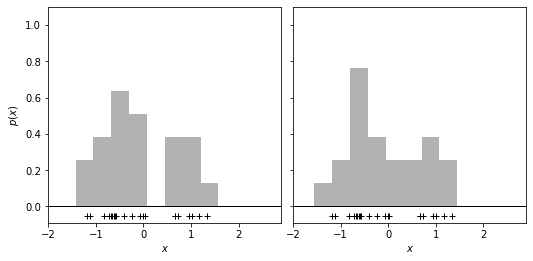

In [3]:
#------------------------------------------------------------
# First figure: silly histogram binning
fig1 = plt.figure(figsize=(8, 4))
fig1.subplots_adjust(left=0.12, right=0.95, wspace=0.05, bottom=0.15, top=0.9, hspace=0.05)

FC = '#6666FF'
XLIM = (-2, 2.9)
YLIM = (-0.09, 1.1)

ax = fig1.add_subplot(121)
bins = np.linspace(-1.8, 2.7, 13)
ax.hist(x, bins=bins, density=True, histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

#Shift bin centers by 0.25
ax = fig1.add_subplot(122)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.hist(x, bins=bins + 0.25, density=True, histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

plt.show()

The underlying distribution in both panels is the same, that is the data points that make up the histogram are the same.  All we have done is shifted the locations of the bins by 0.25.
As we saw in Lecture 2, the choice of bin centers can really change the histogram that we make.

The next panels are what happens if we center the bins on each point.  This is an example of kernel density estimation using a "top-hat" kernel.  It is a good description of the data, but is pretty ugly.

Text(0, 0.5, '$p(x)$')

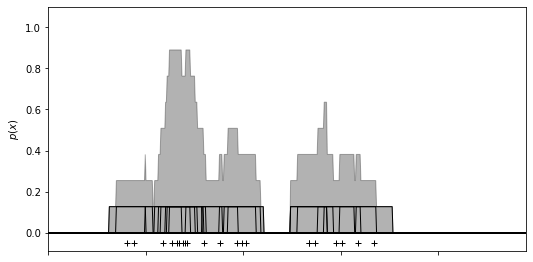

In [4]:
fig1b = plt.figure(figsize=(8, 4))
fig1b.subplots_adjust(left=0.12, right=0.95, wspace=0.05, bottom=0.1, top=0.95, hspace=0.05)

ax = fig1b.add_subplot(111)
ax.xaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = (abs(x_plot - x[:, None]) <= 0.5 * binwidth).astype(float)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_ylabel('$p(x)$')

We can make it look nicer by choosing a different kernel.  That is by choosing a different bin shape.  The next 3 plots show KDEs using **Gaussian kernels** with different width Gaussians.

Text(0.5, 0, '$x$')

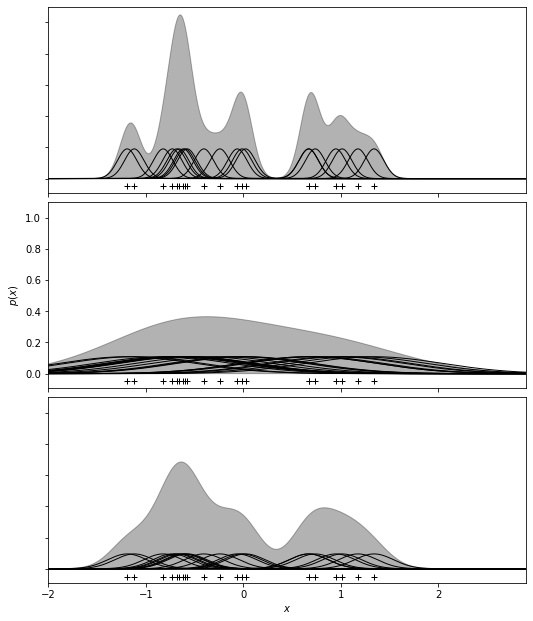

In [5]:
#------------------------------------------------------------
# First figure: transition to KDE
fig2 = plt.figure(figsize=(8, 8))
fig2.subplots_adjust(left=0.12, right=0.95, wspace=0.05, bottom=0.0, top=1.0, hspace=0.05)

ax = fig2.add_subplot(311)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.1)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)

ax = fig2.add_subplot(312)
ax.xaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.7)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, 4 * y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_ylabel('$p(x)$')
ax.set_xlabel('$x$')

ax = fig2.add_subplot(313)
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.2)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

We can think of KDE as replacing the points with "clouds". Each cloud is described by the kernel $K(u)$, where $K(u)$ can be any function that is:
- smooth,
- postive definite,
- normalizes to unity, 
- has zero mean,
- has positive variance. 

The KDE plots above look better, but give us a "Goldilocks" problem.  The first plot uses a kernel that is too narrow.  The second is too wide.  The third is "just right".

A common kernel is the Gaussian kernel that we just used above:

$$K(u) = \frac{1}{(2\pi)^{D/2}}\exp^{-u^2/2}$$

Note that the "$D$" is necessary because while histograms are generally 1-D, the kind of Big Data analysis that we are interested in will be $N$-D.

Once a kernel is chosen the kernel density estimate at a given point, $x$, is given by 
$$ \hat{f}(x) = \frac{1}{Nh^D}\sum_{i=1}^N K\left(\frac{d(x,x_i)}{h}\right),$$
where $\hat{f}$ is an **estimator** of our distribution.

Where does this come from?  Well if you wanted to know the density of points you could compute
$\frac{\sum_1^N\delta (x-x_i)}{V},$ where $\delta (x-x_i)$ is the Delta function, $V$ is the volume, and $N$ is the number of points.  In $D$-dimensional space a volume element is just $h^D$.  Then instead of representing our observation as a delta function, we represent it by our kernel function.  To normalize for the number of points, divide by $N$.

The argument of $K$ is just some measure of the distance between $x$ and each $x_i$.  Normally $d(x,x_i) = (x-x_i)$.  For the gaussian kernel that makes $h=\sigma$.  Take a second to convince yourself that that is the case.  So, you can see how $h$ represents the "width" or what is usually called the **bandwidth** in this context.

You might wonder why the book uses $\hat{f}$ instead of just $f$ since we already are using $f$ instead of $h$ (the true distribution). I don't know, but what they mean is that it is an estimator.

Here is a comparison of some different possible kernels.  The one that I use most commonly is actually an Epanechnikov kernel since the Gaussian and Exponential have rather long tails.
![Ivezic, Figure 6.2](http://www.astroml.org/_images/fig_kernels_1.png)

We won't go through the math, but it turns out that the Epanechnikov kernel is "optimal" in the sense of minimizing the variance.  That kernel is given by $$K(x) = \frac{3}{4}(1-x^2),$$
for $|x|\le 1$ and 0 otherwise. Below is the code that produces the plot above.  

Add the Epanechnikov kernel to it in the color and linestyle of your choice.

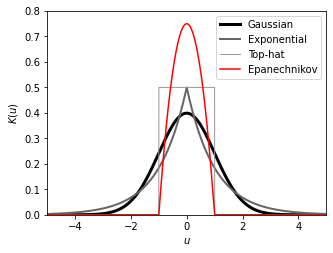

In [12]:
# Complete and Execute
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

#------------------------------------------------------------
# Compute Kernels.
xgrid = np.linspace(-5, 5, 10000)
dx = xgrid[1] - xgrid[0]

gauss = (1. / np.sqrt(2 * np.pi)) * np.exp(-0.5 * xgrid ** 2)

exp = 0.5 * np.exp(-abs(xgrid))

tophat = 0.5 * np.ones_like(xgrid)
tophat[abs(xgrid) > 1] = 0 # Range of the tophat kernel

ep = 0.75*(1-(xgrid*xgrid))  # Add the Epanechnikov kernel function
ep[abs(xgrid) > 1] = 0 # Set the range of the kernel

#------------------------------------------------------------
# Plot the kernels
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

ax.plot(xgrid, gauss, '-', c='black', lw=3, label='Gaussian')
ax.plot(xgrid, exp, '-', c='#666666', lw=2, label='Exponential')
ax.plot(xgrid, tophat, '-', c='#999999', lw=1, label='Top-hat')
ax.plot(xgrid,ep,'-',c='red',label='Epanechnikov')  # Add the Epanechnikov kernel to the plot

ax.legend(loc=1)

ax.set_xlabel('$u$')
ax.set_ylabel('$K(u)$')

ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.8001)
plt.show()

### Bandwidth Determination <a class="anchor" id="two"></a>

When we first discussed histograms and KDE we talked about theoretical computation of optimal bandwidths.  Let's now look at how we can empirically determine the optimal bandwidth through [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

To avoid fooling ourselves into thinking our model is better than it is, we set aside some of the data as the "***test***" set--that provides an independent check on the fit from the ***training data***. 

That's fine if our model has no parameters, or has parameters that are all fixed ahead of time.  But what if we want to try to use the data to not only fit a model, but decide what the best model parameters are?  In that case, we need to set aside some of the training data as a "***validation***" set.  

However, not only does that leave us even less data for training, but it also means that it matters which objects are in each of the training, validation, and test sets.  We can solve both of these problems with **cross validation**.

With our KDE example, we are just trying to map the density, not predict the value, so we really only need two sets: training and validation. There are a number of different ways to do this.

1. You could **randomly sample** to decide which data goes into the training or test sets. We don't just do this once, but rather many times so that each data point is treated both as a training point and as a test point at some stage.


2. We could do this in a more ordered way (e.g., to make sure that each object gets sampled as training/test the same number of times) and do a **$K$-fold cross validation**. Here $K$ is the number of "experiments" that need to be done so that each data point appears in a test sample once.


3. We can take $K$-fold cross validation to the extreme by having $K\equiv N$, so that in each experiment we leave out just one object. This is called **"Leave-One-Out" cross validation**.

### Illustration of Random Sampling
![Random Sample Cross Validation Example; Remesan Figure 3.7](http://i.stack.imgur.com/4Lrff.png)

### Illustration of K-Fold Cross Validation
![K-Fold Cross Validation Example; Remesan Figure 3.8](http://i.stack.imgur.com/fhMza.png)

### Illustration of Leave-One-Out Cross Validation
![Leave-One-Out Cross Validation Example; Remesan Figure 3.9](http://images.slideplayer.com/16/4977882/slides/slide_35.jpg)

Let's go back to our problem of trying to determine the best bandwidth for our Kernel Density Estimate.  

We can do this in Scikit-Learn with [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and replot our histogram above as follows:

In [15]:
# Complete and Execute this cell to determine the bandwidth
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(x[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.1310344827586207


(-0.09, 1.1)

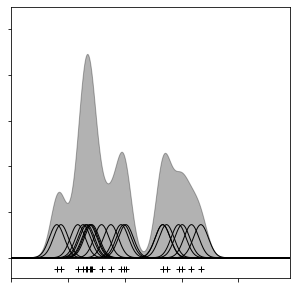

In [16]:
# Execute this cell to see the new "histogram"
fig2 = plt.figure(figsize=(5, 5))
ax = fig2.add_subplot(111)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_grid = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_grid, x[:, None], h_opt)
y_plot /= (binwidth * len(x))
ax.fill(x_grid, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_grid, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)

## 2-D Histograms  <a class="anchor" id="three"></a>

Here is some sample code using [`sklearn.neighbors.KernelDensity`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html).  Play around with this and see how it works.  Make different variations of the plot.  (For example, try `bandwidth=0.01` and `bandwidth=1.0`.)  What we are doing here is using KDE to set the plot color to indicate the relative density of the points.  This is essentially a 2-D histogram.

/tmp/ipykernel_3006/2270687103.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


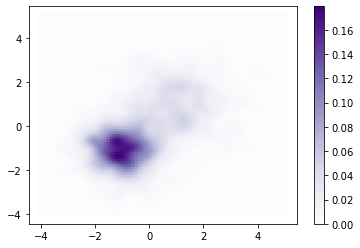

In [22]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity

# Two 2-D normal distributions with offset centroids
# See what happens when you make changes to the next 2 lines.
X = np.concatenate([np.random.normal([-1,-1],[0.75,0.75],size=(1000,2)),np.random.normal([1,1],[1,1],size=(500,2))]) 
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
kde.fit(X) #fit the model to the data

u = v = np.linspace(-4,5,80)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens, cmap="Purples", edgecolor="None")
plt.colorbar()

Now copy the example from above to a new cell and splice in the cross validation code to produce a new plot with the "optimal" bandwidth.  Basically, splice in the lines of code for `GridSearchCV` between the lines setting `X` and instantiating `kde`, choosing an appropriate range of bandwidths to test.  What is the bandwidth that is chosen?

0.1310344827586207


/tmp/ipykernel_3006/1565026009.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


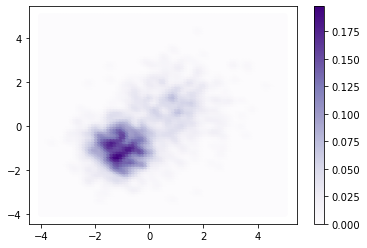

In [23]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity

# Two 2-D normal distributions with offset centroids
# See what happens when you make changes to the next 2 lines.
X = np.concatenate([np.random.normal([-1,-1],[0.75,0.75],size=(1000,2)),np.random.normal([1,1],[1,1],size=(500,2))]) 

bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(x[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X) #fit the model to the data


u = v = np.linspace(-4,5,80)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens, cmap="Purples", edgecolor="None")
plt.colorbar()

## Nearest-Neighbor Density Estimation  <a class="anchor" id="four"></a>

Another very simple way to estimate the density of an $N$-dimensional distribution is to look to the nearest object (or the $K$ nearest objects) and compute their distances, $d_K$.  This is the [$K$-Nearest Neighbor](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) algorithm.  We'll see later that this is also a good method to use for classification.

In this prescription, the density at a given point, $x$ is estimated as

$$\hat{f}_K(x) = \frac{K}{V_D(d_K)}.$$

$V_D(d)$ is given generically by $\frac{2d^D\pi^{D/2}}{D\Gamma(D/2)}$ where $\Gamma$ is the complete gamma function (Equation 3.58) and this formula reduces to the usual equations for area and volume in 2 and 3 dimensions, respectively.

We can simplify this to 
$$\hat{f}_K(x) = \frac{C}{d_K^D}$$
since the constant, $C$, can be evaluated at the end.

N.B. this estimator is **biased**.  What does that mean?

### Aside on Bias (Precision and Accuracy too)  <a class="anchor" id="five"></a>
In this context, it means that our estimator is known to yield a value that is offset from the true value.  What is labeled as "accuracy" here is more correctly called "bias".  This isn't the usual way that you might think of the word, but if you think about it, the meanings are actually consistent.

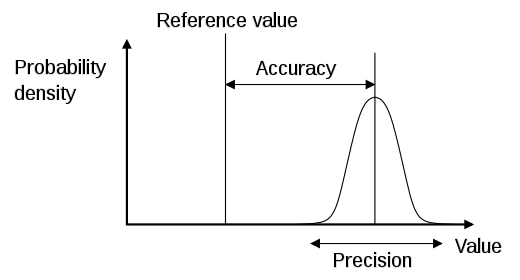

These figures illustrate the difference between bias and precision.  Panel **a** has high **bias** (which is bad) and low **precision** (also bad); it is not very **accurate**.  Panel **b** has low bias and low precision.  Panel **c** has high bias and high precision.  Panel **d** has low bias (which is good) and high precision (which is good); it is very accurate.

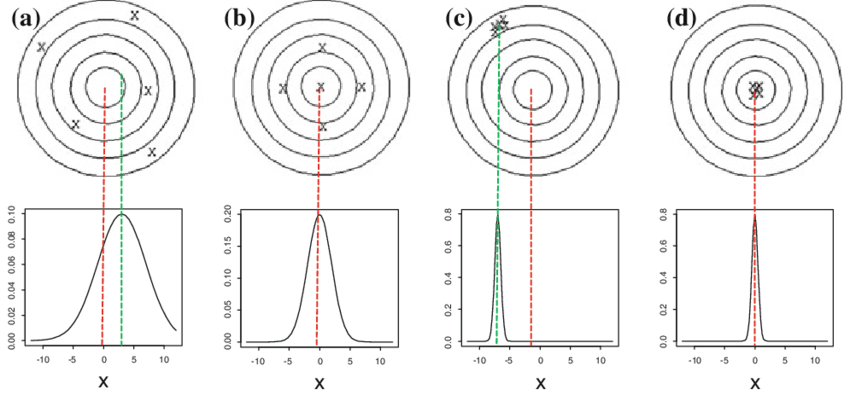

Back to our (nearest-neighbor) density estimator:

$$\hat{f}_K(x) = \frac{C}{d_K^D}.$$

Because this is biased, we don't actually want the *nearest* neighbor, but rather we want something like the *5th* nearest neighbor (or larger).  For example see this figure from the wikipedia link above:

![https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/200px-KnnClassification.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/200px-KnnClassification.svg.png)


In fact, the error in the estimator can be reduced by considering *all* $K$ nearest neighbors:
$$\hat{f}_K(x) = \frac{C}{\sum_{i=1}^K d_i^D}$$

See the [Scikit-Learn `neighbors` documentation](http://scikit-learn.org/stable/modules/neighbors.html) for more information.

Ivezic, Figure 6.5 compares a Nearest Neighbor ($k=10$) with a KDE algorithm.  See what happens as you increase the number of neighbors used.

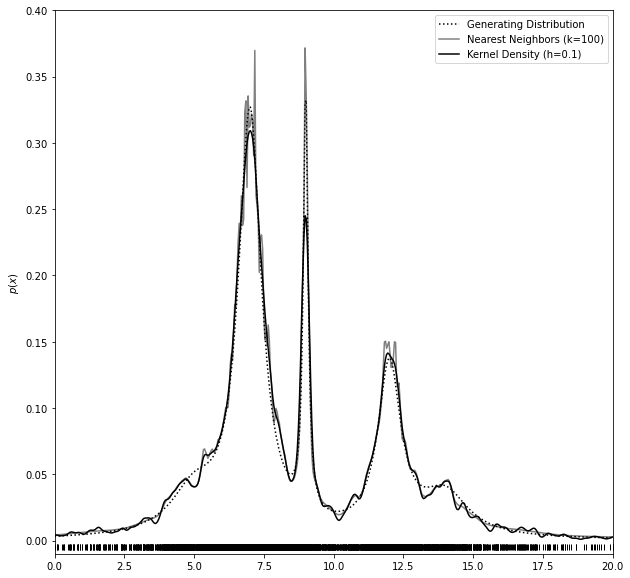

In [30]:
# Based on Ivezic, Figure 6.5
# Modified by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from astroML.density_estimation import KNeighborsDensity
#from astroML.plotting import hist
from astropy.visualization import hist

from sklearn.neighbors import KernelDensity

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x) for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N)) for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 10))
N = 5000
k = 100 #Number of neighbors

xN = x[:N]
t = np.linspace(-10, 30, 1000)

# Compute density with KDE
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(xN[:, None])
dens_kde = np.exp(kde.score_samples(t[:, None]))

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(xN[:, None])
dens_nbrs = nbrs.eval(t[:, None]) / N

# plot the results
plt.plot(t, true_pdf(t), ':', color='black', zorder=3, label="Generating Distribution")
plt.plot(xN, -0.005 * np.ones(len(xN)), '|k')
plt.plot(t, dens_nbrs, '-', lw=1.5, color='gray', zorder=2, label="Nearest Neighbors (k=%i)" % k)
plt.plot(t, dens_kde, '-', color='black', zorder=3, label="Kernel Density (h=0.1)")

# label the plot
#plt.text(0.02, 0.95, "%i points" % N, ha='left', va='top', transform=ax.transAxes)
plt.ylabel('$p(x)$')
plt.legend(loc='upper right')
plt.xlim(0, 20)
plt.ylim(-0.01, 0.4001)

plt.show()

Nearest-neighbors are both pretty simple and pretty powerful.  But you can imagine that they could also be really slow if you have either a lot of points or want to consider a lot of neighbors as  you have to compute all of the pairwise distances!  You can certainly do this "brute force" computation, but the use of **trees** speeds things up considerably.

We haven't talked about **order notation** yet, but now is a good time to introduce it.  If we say that something "goes as $\mathscr{O}(N)$", that means that $N$ operations are needed.  If is it $\mathscr{O}(N^2)$, then $N\times N$ operations are needed.

If we have $N$ samples with $D$ features, then brute force nearest neighbor goes as $\mathscr{O}(DN)$.  That can be a very large number of operations and make our code run slow.  So, can we do it faster?

### Trees  <a class="anchor" id="six"></a>

It seems like you would be stuck computing all of the distances to the neighbors, but consider this:

> if point A is very distant from point B, and point B is very close to point C, then we know that points A and C are very distant.

So, we just have to compute the A-B and B-C distances; we don't actually need to compute A-C.

We can take advantage of this using **trees**.  In 2-D we use a [**quad-tree**](https://en.wikipedia.org/wiki/Quadtree), which is illustrated in Ivezic, Figure 2.3 below.

![Ivezic, Figure 2.3](http://www.astroml.org/_images/fig_quadtree_example_1.png)

What is happening is that the data space gets broken down into smaller and smaller bins.  Then instead of computing the distances between each of the *objects*, we compute the distances between each of the *bins*.  We only compute the distances between objects if the bin distances are small enough to be considered further.  This process can speed up nearest neighbor finding considerably.  

For a quad-tree we are specifically dividing the 2-D space into 4 equal "nodes" (children) until each box is either empty or has no more than some number of points.  The terminal nodes are called "leaves", thus the name "tree".  In 3-D we instead have **oct-trees**.  

We can generalize this to $k$ dimensions but the scaling as $2^D$ quickly gets out of control and is called the [**curse of dimensionality**](https://en.wikipedia.org/wiki/Curse_of_dimensionality) (more on that next week).   So for so-called [**$k$D-tree**](https://en.wikipedia.org/wiki/K-d_tree) we instead use *binary* trees where each node has 2 children instead of 4.   $k$D trees further split the *data* into two rather than the box into two.  A $k$D-tree is illustrated in Ivezic, Figure 2.4 below.

![Ivezic, Figure 2.4](http://www.astroml.org/_images/fig_kdtree_example_1.png)

Note that empty leaves are not created because you are always splitting the data, not the space in half.

For $k$D trees no $D$-dimensional distances need to be computed, so once the tree is constructed, the nearest neighbor determination is only $\mathscr{O}(D \log N)$.

In Scikit-Learn $k$D Trees are implemented in [http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree)

As long as $D$ isn't *too* large ($\lesssim 20$), this works well, but $k$D trees also suffer from the curse of dimensionality for large $D$ and go as $\mathscr{O}(DN)$. In that case, we can use [**ball-trees**](https://en.wikipedia.org/wiki/Ball_tree) instead.  

Instead of using Cartesian axes, ball-trees split the data into nesting hyper spheres.  This makes it more "expensive" to build the tree, but it makes finding the nearest neighbors faster $\mathscr{O}(D \log N)$.

For more information on ball-trees in Scikit-Learn, see [http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

An example from Ivezic is shown below
![Ivezic, Figure 2.5](http://www.astroml.org/_images/fig_balltree_example_1.png)

### Creating an evaluation grid   <a class="anchor" id="seven"></a>

Now let's look at nearest neighbors in 2-D.  Note that for 1-D we had to define the "grid" over which we evaluated the pdf and we did something like 

```xgrid = np.linspace(-10, 30, 1000)```

We need to do the same in 2-D.  That seems easy enough, right?  If $x$ runs from 0 to 10 and $y$ runs from 0 to 10 and we want to evaluate in steps of 1 in each direction, then we just need to build a grid that includes the points, $(0,0), (1,0), (0,1) \dots (10,9), (9,10), (10,10)$. 

As far as I know there is no simple tool that does this.  But we can use [`np.meshgrid()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) to help us as follows

In [31]:
xgrid = np.linspace(0,10,11)
ygrid = np.linspace(0,10,11)

print(xgrid,ygrid)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [32]:
xv,yv = np.meshgrid(xgrid,ygrid)
print(xv)
print(yv)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
 [ 7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.]
 [10. 10. 10

In [34]:
print(xv.ravel())
print(yv.ravel())
# Equivalent to flatten(), except for making a copy (or not) of the array

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.
  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.
  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.
 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.
  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.
  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.
  9.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [35]:
xystack = np.vstack([xv.ravel(),yv.ravel()])
print(xystack)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.
   7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.
   3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.
  10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.
   6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.
   2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.
   9. 10.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.
   3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
   4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.
   6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.
   8.  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.
   9.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]


In [36]:
Xgrid = xystack.T
print(Xgrid)

[[ 0.  0.]
 [ 1.  0.]
 [ 2.  0.]
 [ 3.  0.]
 [ 4.  0.]
 [ 5.  0.]
 [ 6.  0.]
 [ 7.  0.]
 [ 8.  0.]
 [ 9.  0.]
 [10.  0.]
 [ 0.  1.]
 [ 1.  1.]
 [ 2.  1.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  1.]
 [ 7.  1.]
 [ 8.  1.]
 [ 9.  1.]
 [10.  1.]
 [ 0.  2.]
 [ 1.  2.]
 [ 2.  2.]
 [ 3.  2.]
 [ 4.  2.]
 [ 5.  2.]
 [ 6.  2.]
 [ 7.  2.]
 [ 8.  2.]
 [ 9.  2.]
 [10.  2.]
 [ 0.  3.]
 [ 1.  3.]
 [ 2.  3.]
 [ 3.  3.]
 [ 4.  3.]
 [ 5.  3.]
 [ 6.  3.]
 [ 7.  3.]
 [ 8.  3.]
 [ 9.  3.]
 [10.  3.]
 [ 0.  4.]
 [ 1.  4.]
 [ 2.  4.]
 [ 3.  4.]
 [ 4.  4.]
 [ 5.  4.]
 [ 6.  4.]
 [ 7.  4.]
 [ 8.  4.]
 [ 9.  4.]
 [10.  4.]
 [ 0.  5.]
 [ 1.  5.]
 [ 2.  5.]
 [ 3.  5.]
 [ 4.  5.]
 [ 5.  5.]
 [ 6.  5.]
 [ 7.  5.]
 [ 8.  5.]
 [ 9.  5.]
 [10.  5.]
 [ 0.  6.]
 [ 1.  6.]
 [ 2.  6.]
 [ 3.  6.]
 [ 4.  6.]
 [ 5.  6.]
 [ 6.  6.]
 [ 7.  6.]
 [ 8.  6.]
 [ 9.  6.]
 [10.  6.]
 [ 0.  7.]
 [ 1.  7.]
 [ 2.  7.]
 [ 3.  7.]
 [ 4.  7.]
 [ 5.  7.]
 [ 6.  7.]
 [ 7.  7.]
 [ 8.  7.]
 [ 9.  7.]
 [10.  7.]
 [ 0.  8.]
 [ 1.  8.]
 [ 2.  8.]

Note that, while I said that there is no built in function for this, there are any number of ways to accomplish this!  For example, using `map`, `np.mgrid()`, transposes, etc.

The code below accomplishes it in just one line, but I thought that it would make more sense if we broke it down like we did above.

In [37]:
# Comparison of KDE and K-Nearest Neighbors "smoothing"
# Based on Ivezic, Figure 6.4, but modified by GTR

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from scipy.spatial import cKDTree

from astroML.datasets import fetch_great_wall
#from astroML.density_estimation import KDE, KNeighborsDensity
from astroML.density_estimation import KNeighborsDensity
from sklearn.neighbors import KernelDensity

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx), np.linspace(ymin, ymax, Ny)))).T

#print Xgrid

#kde = KDE(metric='gaussian', h=5)
kde = KernelDensity(kernel='gaussian', bandwidth=5)
dens_KDE = np.exp(kde.fit(X).score_samples(Xgrid).reshape((Ny, Nx)))

knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

knn40 = KNeighborsDensity('bayesian', 40)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: KDE
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(np.exp(dens_KDE.T), origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "KDE: Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: KNN, k=5
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens_k5.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "$k$-neighbors $(k=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Fourth plot: KNN, k=40
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens_k40.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "$k$-neighbors $(k=40)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

KeyboardInterrupt: 

What the "right" answer is depends on what you want to do with the data.  

Next time we'll talk about Gaussian Mixture Models and K-Means Clustering.

To get started for next time, let's learn how to read in a data sample that we are going to use.

http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat

In [38]:
#eruptions: Eruption time in mins
#waiting: Waiting time to next eruption
import pandas as pd
df = pd.read_csv('../data/faithful.dat', delim_whitespace=True)
df.head()

,N,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85


Make two "fancy" histograms illustrating the distribution of `x=df['eruptions']` and `y=df['waiting']` times.  Use `bins="freedman"` and `histtype="step"`.

Text(0, 0.5, 'N')

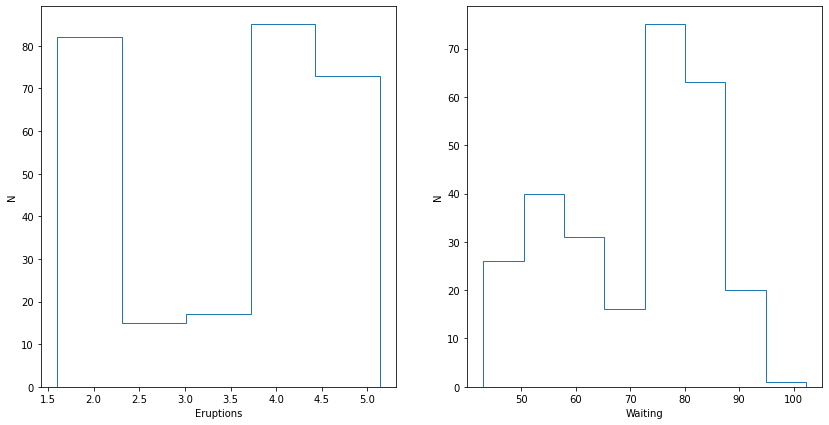

In [45]:
from astropy.visualization import hist as fancyhist

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
fancyhist(df['eruptions'], bins ='freedman',histtype='step')
plt.xlabel('Eruptions')
plt.ylabel('N')

ax = fig.add_subplot(122)
fancyhist(df['waiting'],bins ='freedman',histtype='step')
plt.xlabel('Waiting')
plt.ylabel('N')

Now make a 2-D scatter plot with `plt.scatter()`.

Text(0, 0.5, 'Waiting')

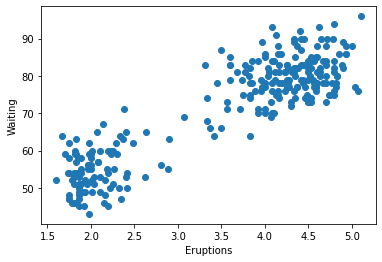

In [46]:
plt.scatter(df['eruptions'],df['waiting'])
plt.xlabel('Eruptions')
plt.ylabel('Waiting')